# Imports

In [10]:
from graph_tool.all import *
import os
import sys
import shutil
import math
from typing import *
from enum import Enum
import datetime
import numpy as np
import pandas as pd
from MotifSignifanceCalculationForPHDProp import *
import matplotlib.pyplot as plt

# Reading a sample graph (a subgraph of the complete graph)

In [2]:
exp_graph_path = '/Users/yishaiazabary/PycharmProjects/University/BrainVasculatureGraphs/Data/GBM_Tumor_Graphs/graph_annotated.gt'
g = load_graph(exp_graph_path)

In [3]:
print(f"Raw graph basic attributes:")
print(f"#vertices: {g.num_vertices()}, #edges: {g.num_edges()}")

#vertices: 167647, #edges: 208628


# Cleaning the graph

In [4]:
remove_parallel_edges(g)
remove_self_loops(g)

In [6]:
print(f"Graph basic attributes with self loops and parallel edges removed:")
print(f"#vertices: {g.num_vertices()}, #edges: {g.num_edges()}")
print(f"graph is {''if g.is_directed() else 'not'} directed")

Graph basic attributes with self loops and parallel edges removed:
#vertices: 167647, #edges: 196881
graph is not directed


# drawing the graph

In [80]:
graph_draw(g, pos=g.vp['coordinates'], output='gbm_1st_graph.pdf')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x169745dd0, at 0x17d939d50>

In [7]:
list(g.ep.keys())

['length', 'artery_binary', 'artery_raw', 'radii', 'edge_geometry_indices']

# immune cells presence

In [6]:
np.unique(g.ep['artery_raw'].a, return_counts=True)

(PropertyArray([  127.,   132.,   136., ..., 15730., 16948., 30324.]),
 array([1, 4, 2, ..., 3, 7, 1]))

## Immune cell presence in edges by radii

### Calculate graph edges radii bins

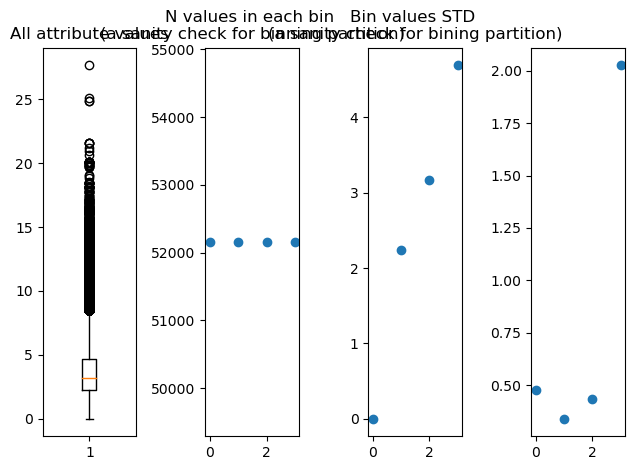

In [32]:
def get_all_edges_attribute(g: Graph, attribute_to_get: Tuple[str, str]=("e", "radii")) -> np.array:
    return g.properties[attribute_to_get].a

def calculate_attribute_bins(data: np.array, n_bins: int=4, **kwargs)->np.array:
    sorted_data = sorted(data, key=kwargs.get("sorting_key_func", lambda x: x))
    n_data_points_per_bin = data.shape[0] // n_bins
    data_partitioned_to_bins = np.vstack([sorted_data[_ * n_data_points_per_bin: (_+1)*n_data_points_per_bin] for _ in range(n_bins)])
    bins_limits = np.array([np.min(bin_data) for bin_data in data_partitioned_to_bins])
    if kwargs.get("return_bins_limits", True):
        return data_partitioned_to_bins, bins_limits
    else:
        return data_partitioned_to_bins

def plot_basic_binning_partitions_attributes(data: np.array, data_partitioned_to_bins: np.array, bins_limits: np.array)->None:
    fig, axis = plt.subplots(1,4)
    axis[0].boxplot(data)
    axis[0].set_title(f"All attribute values")
    axis[1].scatter([_ for _, partition in enumerate(data_partitioned_to_bins)], [len(partition) for _, partition in enumerate(data_partitioned_to_bins)])
    axis[1].set_title(f"N values in each bin \n(a sanity check for binning partition)")
    axis[2].scatter([_ for _, partition in enumerate(bins_limits)], [partition for _, partition in enumerate(bins_limits)])
    axis[2].set_title(f"Bin limits \n(a sanity check for bining partition)")
    axis[3].scatter([_ for _, partition in enumerate(data_partitioned_to_bins)], [np.std(partition) for _, partition in enumerate(data_partitioned_to_bins)])
    axis[2].set_title(f"Bin values STD \n(a sanity check for bining partition)")
    plt.tight_layout()
    plt.show()

graph_edges_radiis = get_all_edges_attribute(g)
radii_partitioned_to_bins, radii_bins_limits = calculate_attribute_bins(data=graph_edges_radiis)
plot_basic_binning_partitions_attributes(data=graph_edges_radiis, data_partitioned_to_bins=radii_partitioned_to_bins, bins_limits=radii_bins_limits)


In [77]:
def partition_edges_to_attribute_bins(_g: Graph, bins: np.array, attribute: str='radii', **kwargs) -> Union[List[List[Edge]], Tuple[List[List[Edge]], List[List[Any]]]]:
    edges_in_bins = [[] for _ in range(len(bins))]
    attribute_to_collect_values = [[] for _ in range(len(bins))]
    for edge_idx, edge in enumerate(_g.edges()):
        edge_attribute_value = g.ep[attribute][edge]
        edge_bin_idx = np.digitize(edge_attribute_value, bins=bins, right=kwargs.get("bin_includes_right_lim_value", False))
        edges_in_bins[edge_bin_idx-1].append(edge)
        attribute_to_collect_values[edge_bin_idx-1].append(g.ep[kwargs.get("attribute_to_collect", "artery_raw")][edge])
    if kwargs.get("return_edges_attributes_values", True):
        return edges_in_bins, attribute_to_collect_values
    return edges_in_bins
def plot_binning_values_basics_as_boxplots(partitioned_bins_values: Union[np.array, List[List[Union[int, float]]]], bin_limits: Union[np.array, None]=None, attribute_partitioned_by: Union[str, None] = None) -> None:
    fig, axis = plt.subplots(1,2)
    axis[0].boxplot(partitioned_bins_values)
    axis[0].set_title(f"Binning partition values distribution")
    if bin_limits is not None and attribute_partitioned_by is not None:
        axis[0].set_xticks(np.arange(1, len(bin_limits)+1, 1))
        axis[0].set_xticklabels([f"{partition:.2f} - {f'{bin_limits[_ + 1]:.2f}' if len(bin_limits)-1 > _ else 'inf'}" for _, partition in enumerate(bin_limits)], rotation=90)
        axis[0].set_xlabel(f"Bins by {attribute_partitioned_by}")
    axis[1].scatter(np.arange(0, len(partitioned_bins_values), 1),  [len(bin_vals) for bin_vals in partitioned_bins_values])
    axis[1].set_title(f"Binning partition values counts")
    if bin_limits is not None and attribute_partitioned_by is not None:
        axis[1].set_xticks(np.arange(0, len(bin_limits), 1))
        axis[1].set_xticklabels([f"{partition:.2f} - {f'{bin_limits[_ + 1]:.2f}' if len(bin_limits)-1 > _ else 'inf'}" for _, partition in enumerate(bin_limits)], rotation=90)
        axis[1].set_xlabel(f"Bins by {attribute_partitioned_by}")
    plt.tight_layout()
    plt.show()

In [61]:
edges_with_immune_binary_bins_by_edge_radii = partition_edges_to_attribute_bins(
    _g=g,
    bins=radii_bins_limits)

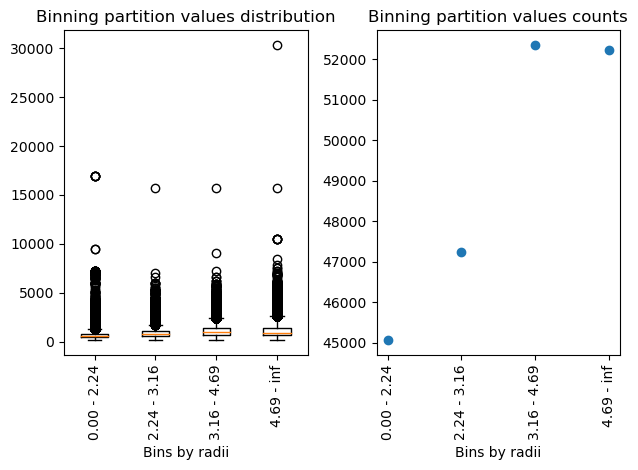

In [78]:
plot_binning_values_basics_as_boxplots(edges_with_immune_binary_bins_by_edge_radii[1],
                                       bin_limits=radii_bins_limits,
                                       attribute_partitioned_by="radii")

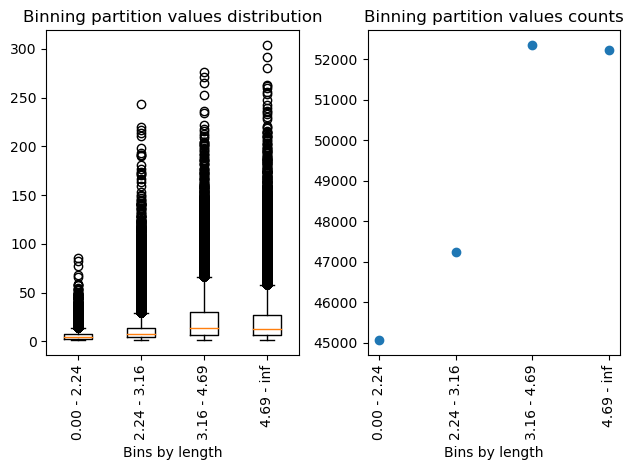

In [79]:
edges_with_immune_binary_bins_by_edge_length = partition_edges_to_attribute_bins(
    _g=g,
    bins=radii_bins_limits,
    attribute_to_collect='length')
plot_binning_values_basics_as_boxplots(edges_with_immune_binary_bins_by_edge_length[1],
                                       bin_limits=radii_bins_limits,
                                       attribute_partitioned_by='length')

## Immune cell presence in edges by length

# Calculating "regular" motifs

In [6]:
from graph_tool.clustering import motifs, motif_significance

In [7]:
motif_size = 4
reg_motifs, reg_motifs_zscores, reg_motif_counts, reg_motifs_avg_counts_in_random_graphs, reg_motifs_std_counts_in_random_graphs = motif_significance(g, k=motif_size, full_output=True)

In [8]:
_motifs, motifs_cnts, motifs_vertex_properties = motifs(g, k=motif_size, p=1.0, return_maps=True)

In [9]:
reg_motifs_full_results = list(zip(reg_motifs, reg_motifs_zscores, reg_motif_counts, reg_motifs_avg_counts_in_random_graphs, reg_motifs_std_counts_in_random_graphs))

In [10]:
def get_edge_attribute_values_aggregation_from_lst_of_vertices(g: Graph, motifs_vertices_lst: List[int],
                                                               attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                               aggregation_method=np.sum,
                                                               repeat_edge_allowed: bool=False):
    visited_edges = set()
    attribute_values_to_aggregate = []
    for vertices_lst in motifs_vertices_lst:
        for vertex_id in vertices_lst:
            v = g.vertex(vertex_id)
            v_edges = v.all_edges()
            v_edges_as_tuples = []
            for edge in v_edges:
                edge_as_tuple = (edge.source(), edge.target())
                if not repeat_edge_allowed and (edge_as_tuple in visited_edges or edge_as_tuple[::-1] in visited_edges):
                    continue
                v_edges_as_tuples.append(edge_as_tuple)
                edge_attribute_val = g.properties[attribute_to_aggregate][edge]
                attribute_values_to_aggregate.append(edge_attribute_val)
            visited_edges.update(set(v_edges_as_tuples))
    return aggregation_method(attribute_values_to_aggregate)

In [11]:
from MotifSignifanceCalculationForPHDProp import *


motifs_immune_count = {}
_motifs, _motifs_counts, _motifs_vertices_indices = remove_duplicate_motifs_keep_counts_and_vertices_indices(_motifs=_motifs,
                                                                                                             motifs_cnts=motifs_cnts,
                                                                                                             motifs_vertices_indices=motifs_vertex_properties)
for motif, motif_vertex_lsts in zip(_motifs, motifs_vertex_properties):
    motifs_immune_count[motif] = get_edge_attribute_values_aggregation_from_lst_of_vertices(g, motif_vertex_lsts)

### Plot #immune cells containing edges in motifs by motif type

In [10]:
all_motifs_type_colors = {}
def tmp_get_flag(motif_type, v_color):
    if not os.path.isdir('tmp'):
        os.makedirs('tmp')
    graph_draw(motif_type, output='tmp/t.png', output_size=(30, 30), vertex_fill_color=v_color)
    path = "tmp/t.png"
    im = plt.imread(path)
    return im

def tmp_get_motif_color(_motif) -> np.array:
    global all_motifs_type_colors

    if all_motifs_type_colors.get(_motif, None) is None:
        motif_type_color = list(np.random.choice(np.arange(0.3, 1., 0.1), size=3)) + [0.9]
        all_motifs_type_colors[_motif] = motif_type_color
    return all_motifs_type_colors[_motif]

def tmp_offset_image(coord, motif_type, ax):
    global all_motifs_type_colors
    v_color = tmp_get_motif_color(motif_type) #all_motifs_type_colors[motif_type]
    img = tmp_get_flag(motif_type, v_color=v_color)
    im = OffsetImage(img, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0), xybox=(0., -30.), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)
def tmp_plot_motif_cnts_per_type(motifs_types, valuesA, subgraph_name, path_to_save_plot_dir=None, motifs_len: int = 4):
    """
    plots with motifs ilustration (graph_draw) as axis labels
    """
    fig, ax = plt.subplots(figsize=(30, 20))

    ax.bar(range(len(motifs_types)), valuesA, width=0.5, align="center")
    ax.set_xticks(range(len(motifs_types)))
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', pad=26)

    for bars in ax.containers:
        ax.bar_label(bars)

    ax.set_title(f"{subgraph_name} counts")

    #     plt.tight_layout()

    for i, motif_type in enumerate(motifs_types):
        tmp_offset_image(i, motif_type, ax)
    if path_to_save_plot_dir is None:
        plt.show()
    else:
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.png") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.png"
        plt.savefig(path_to_save_plot, dpi=300)
        path_to_save_plot = os.path.join(path_to_save_plot_dir, f"{subgraph_name}_{motifs_len}.eps") if path_to_save_plot_dir != "" else f"{subgraph_name}_{motifs_len}.eps"
        plt.savefig(path_to_save_plot, dpi=300)

tmp_plot_motif_cnts_per_type(motifs_types=list(motifs_immune_count.keys()), valuesA=list(motifs_immune_count.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph")

NameError: name 'motifs_immune_count' is not defined

### Plot motifs #appearances in network by motif type


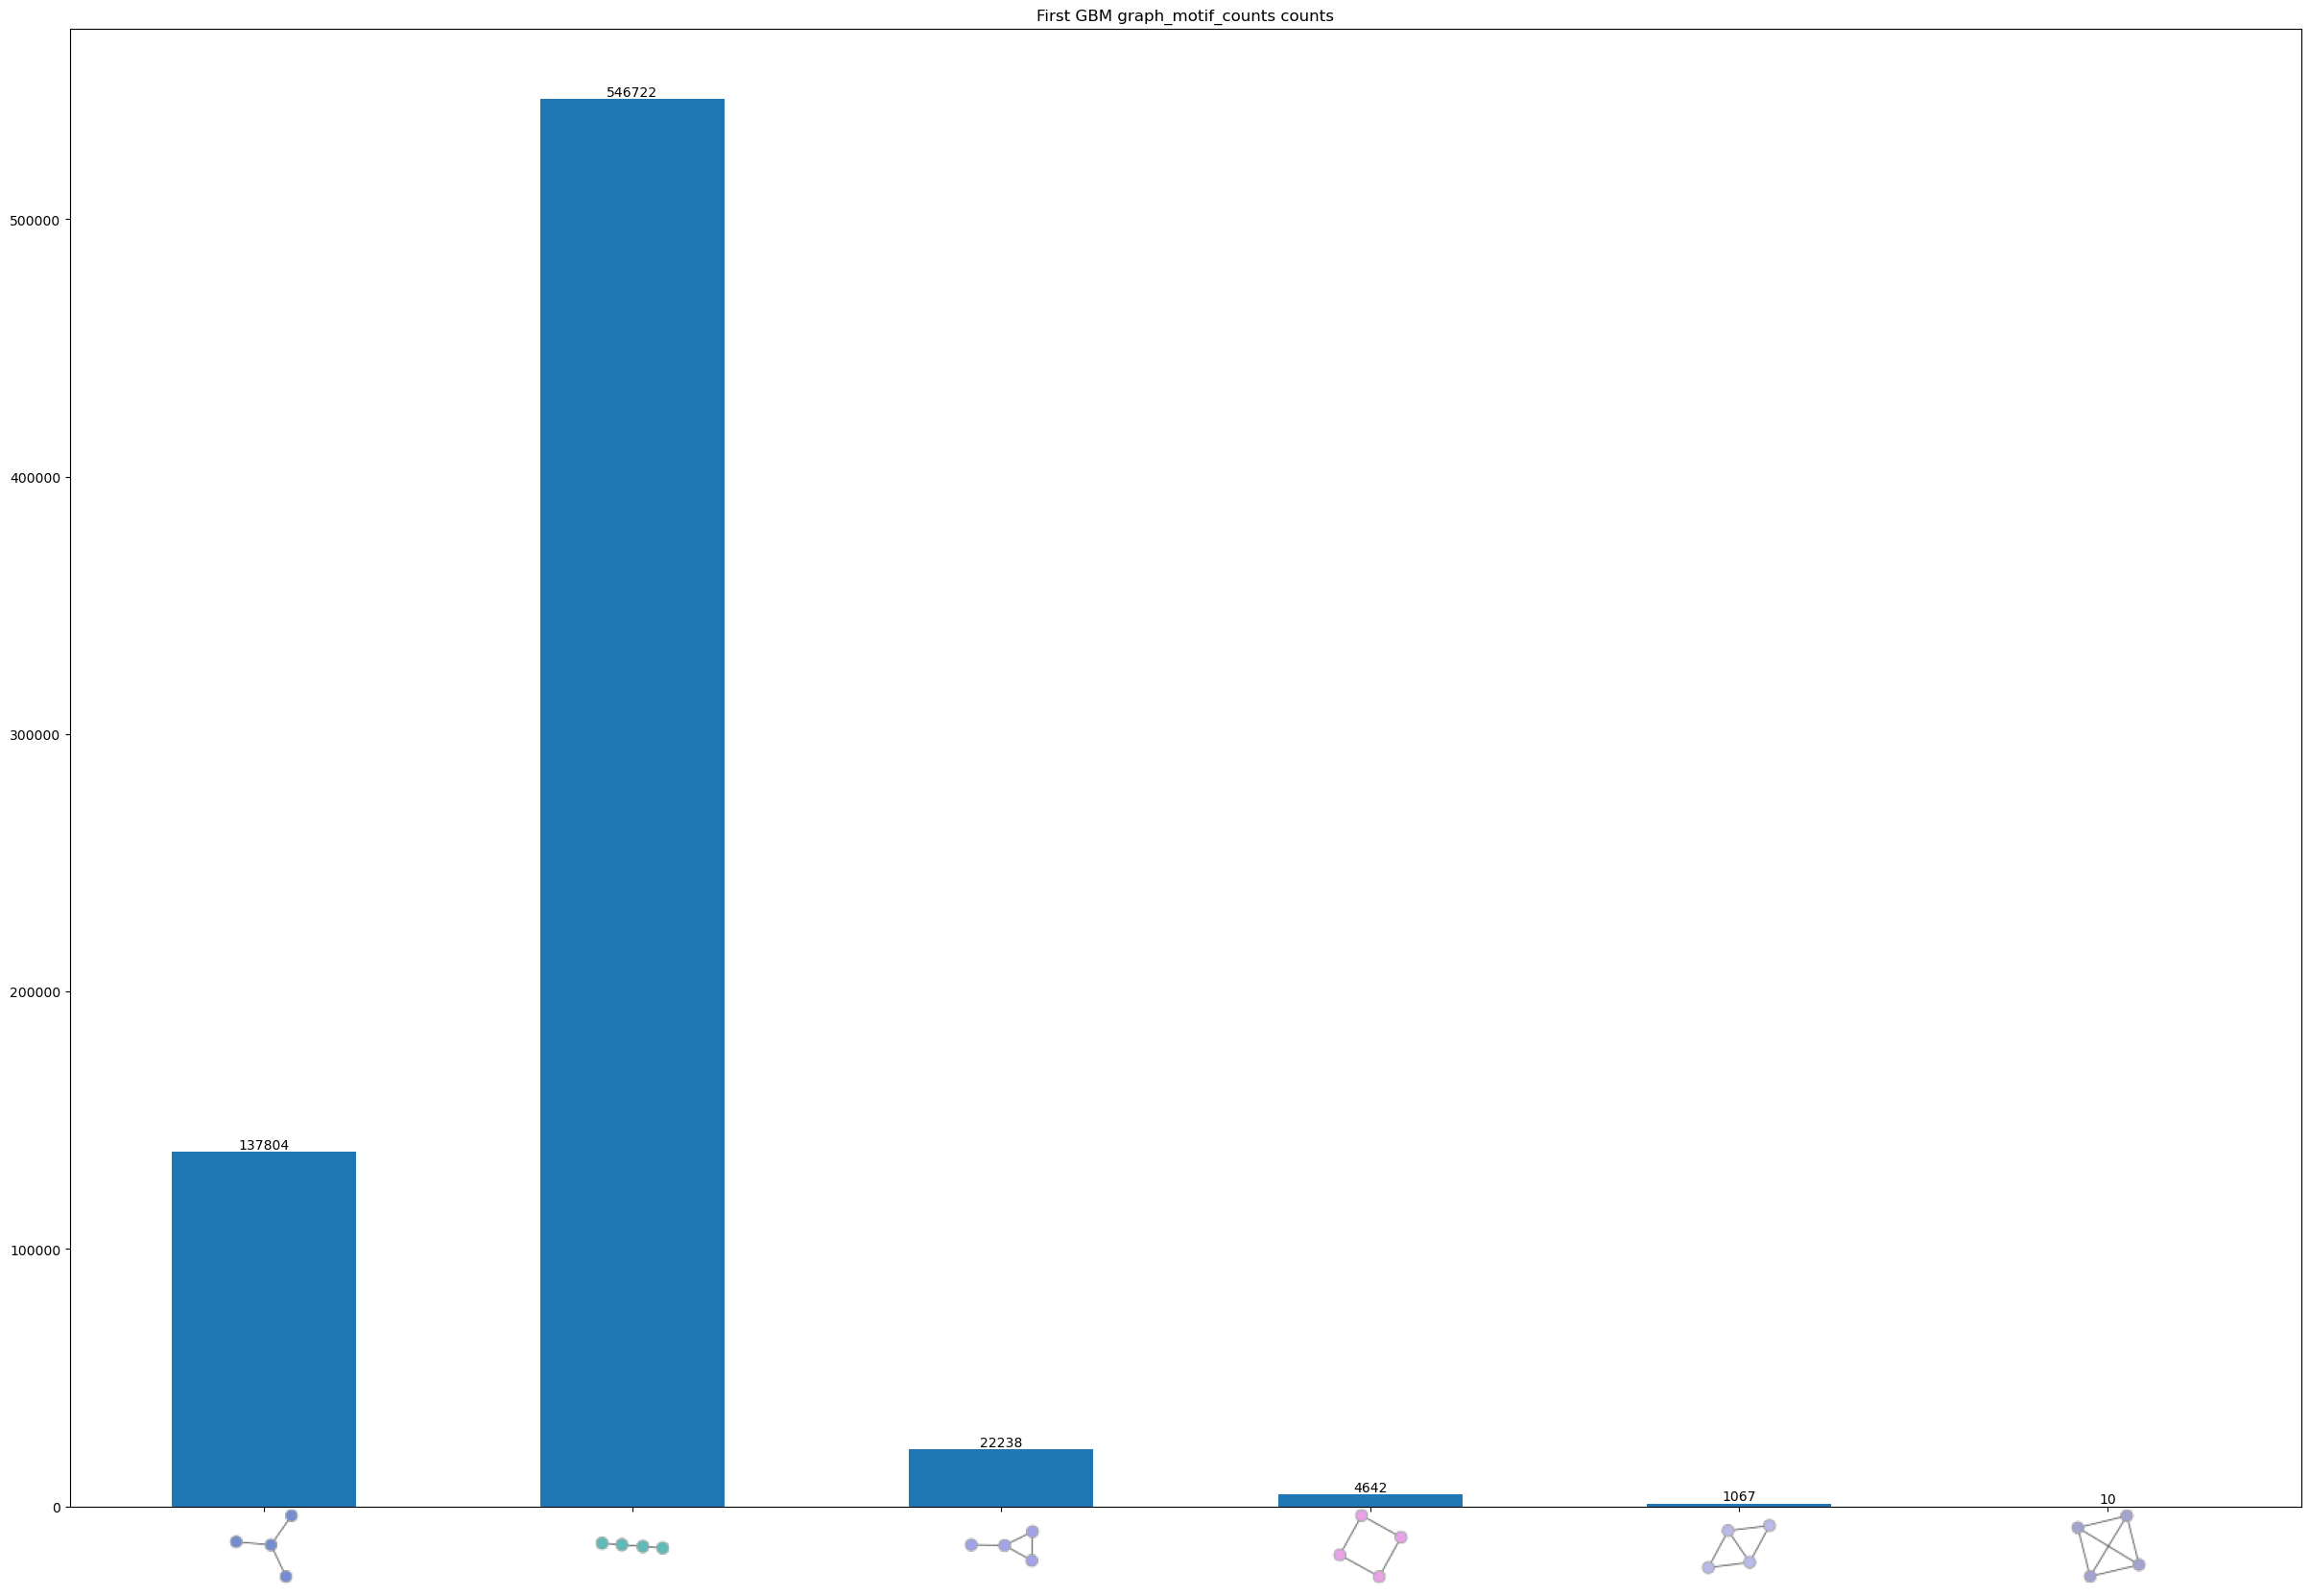

In [19]:
tmp_plot_motif_cnts_per_type(motifs_types=list(motifs_immune_count.keys()), valuesA=_motifs_counts, path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_counts")

### Calculate fraction of motifs containing immune cells in edges by motif type


In [46]:
from itertools import combinations, permutations
def get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(g: Graph,
                                                                              motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],
                                                                              #motifs_vertices_lst: List[List[int]] = None,
                                                                               attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                               repeat_edge_allowed: bool=False,
                                                                              ):
    n_motifs_instances_with_attribute_num_dict = {}
    n_motifs_instances_without_attribute_num_dict = {}
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        visited_edges_in_motif_type = set()
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif)
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges)))
            found_in_motif = False
            for edge in existing_edges_in_motif: # iterate over all edges in the motif instance
                if not repeat_edge_allowed and edge in visited_edges_in_motif_type: # repeats allowed in motif type?
                    visited_edges_in_motif_type.update({edge})
                    continue
                # check if the edge contains the target attribute (i.e. not zero)
                is_edge_with_attribute = bool(g.properties[attribute_to_aggregate][edge])
                if is_edge_with_attribute:
                    n_motifs_instances_with_attribute_num_dict[motif_type] = n_motifs_instances_with_attribute_num_dict.get(motif_type, 0) + 1
                    found_in_motif = True # if found in a single edge, move to next motif instance
                    break
            # if not found in any edge of the motif instance, update motifs instances without attribute counter
            if not found_in_motif:
                n_motifs_instances_without_attribute_num_dict[motif_type] = n_motifs_instances_without_attribute_num_dict.get(motif_type, 0) + 1

    motifs_with_attribute_fractions_dict = {_motif_type: n_motifs_instances_with_attribute_num_dict.get(_motif_type, 0)/
                                            (n_motifs_instances_with_attribute_num_dict.get(_motif_type, 0) + n_motifs_instances_without_attribute_num_dict.get(_motif_type, 0))
                                            for _motif_type in set(list(n_motifs_instances_with_attribute_num_dict.keys()) + list(n_motifs_instances_without_attribute_num_dict.keys()))}

    return motifs_with_attribute_fractions_dict

In [12]:
motifs_vertices_lsts_dict = {
    _motifs[motif_idx]: motifs_vertex_properties[motif_idx] for motif_idx in range(len(_motifs))
}

In [47]:
motifs_instances_fraction_with_attributes_repeat_edges_allowed = get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    repeat_edge_allowed=True
)
motifs_instances_fraction_with_attributes_repeat_edges_not_allowed = get_edge_existing_attribute_fractions_from_motifs_aggregation_from_lst_of_vertices(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    repeat_edge_allowed=False
)

### Plot fraction of motifs containing immune cells in edges by motif type


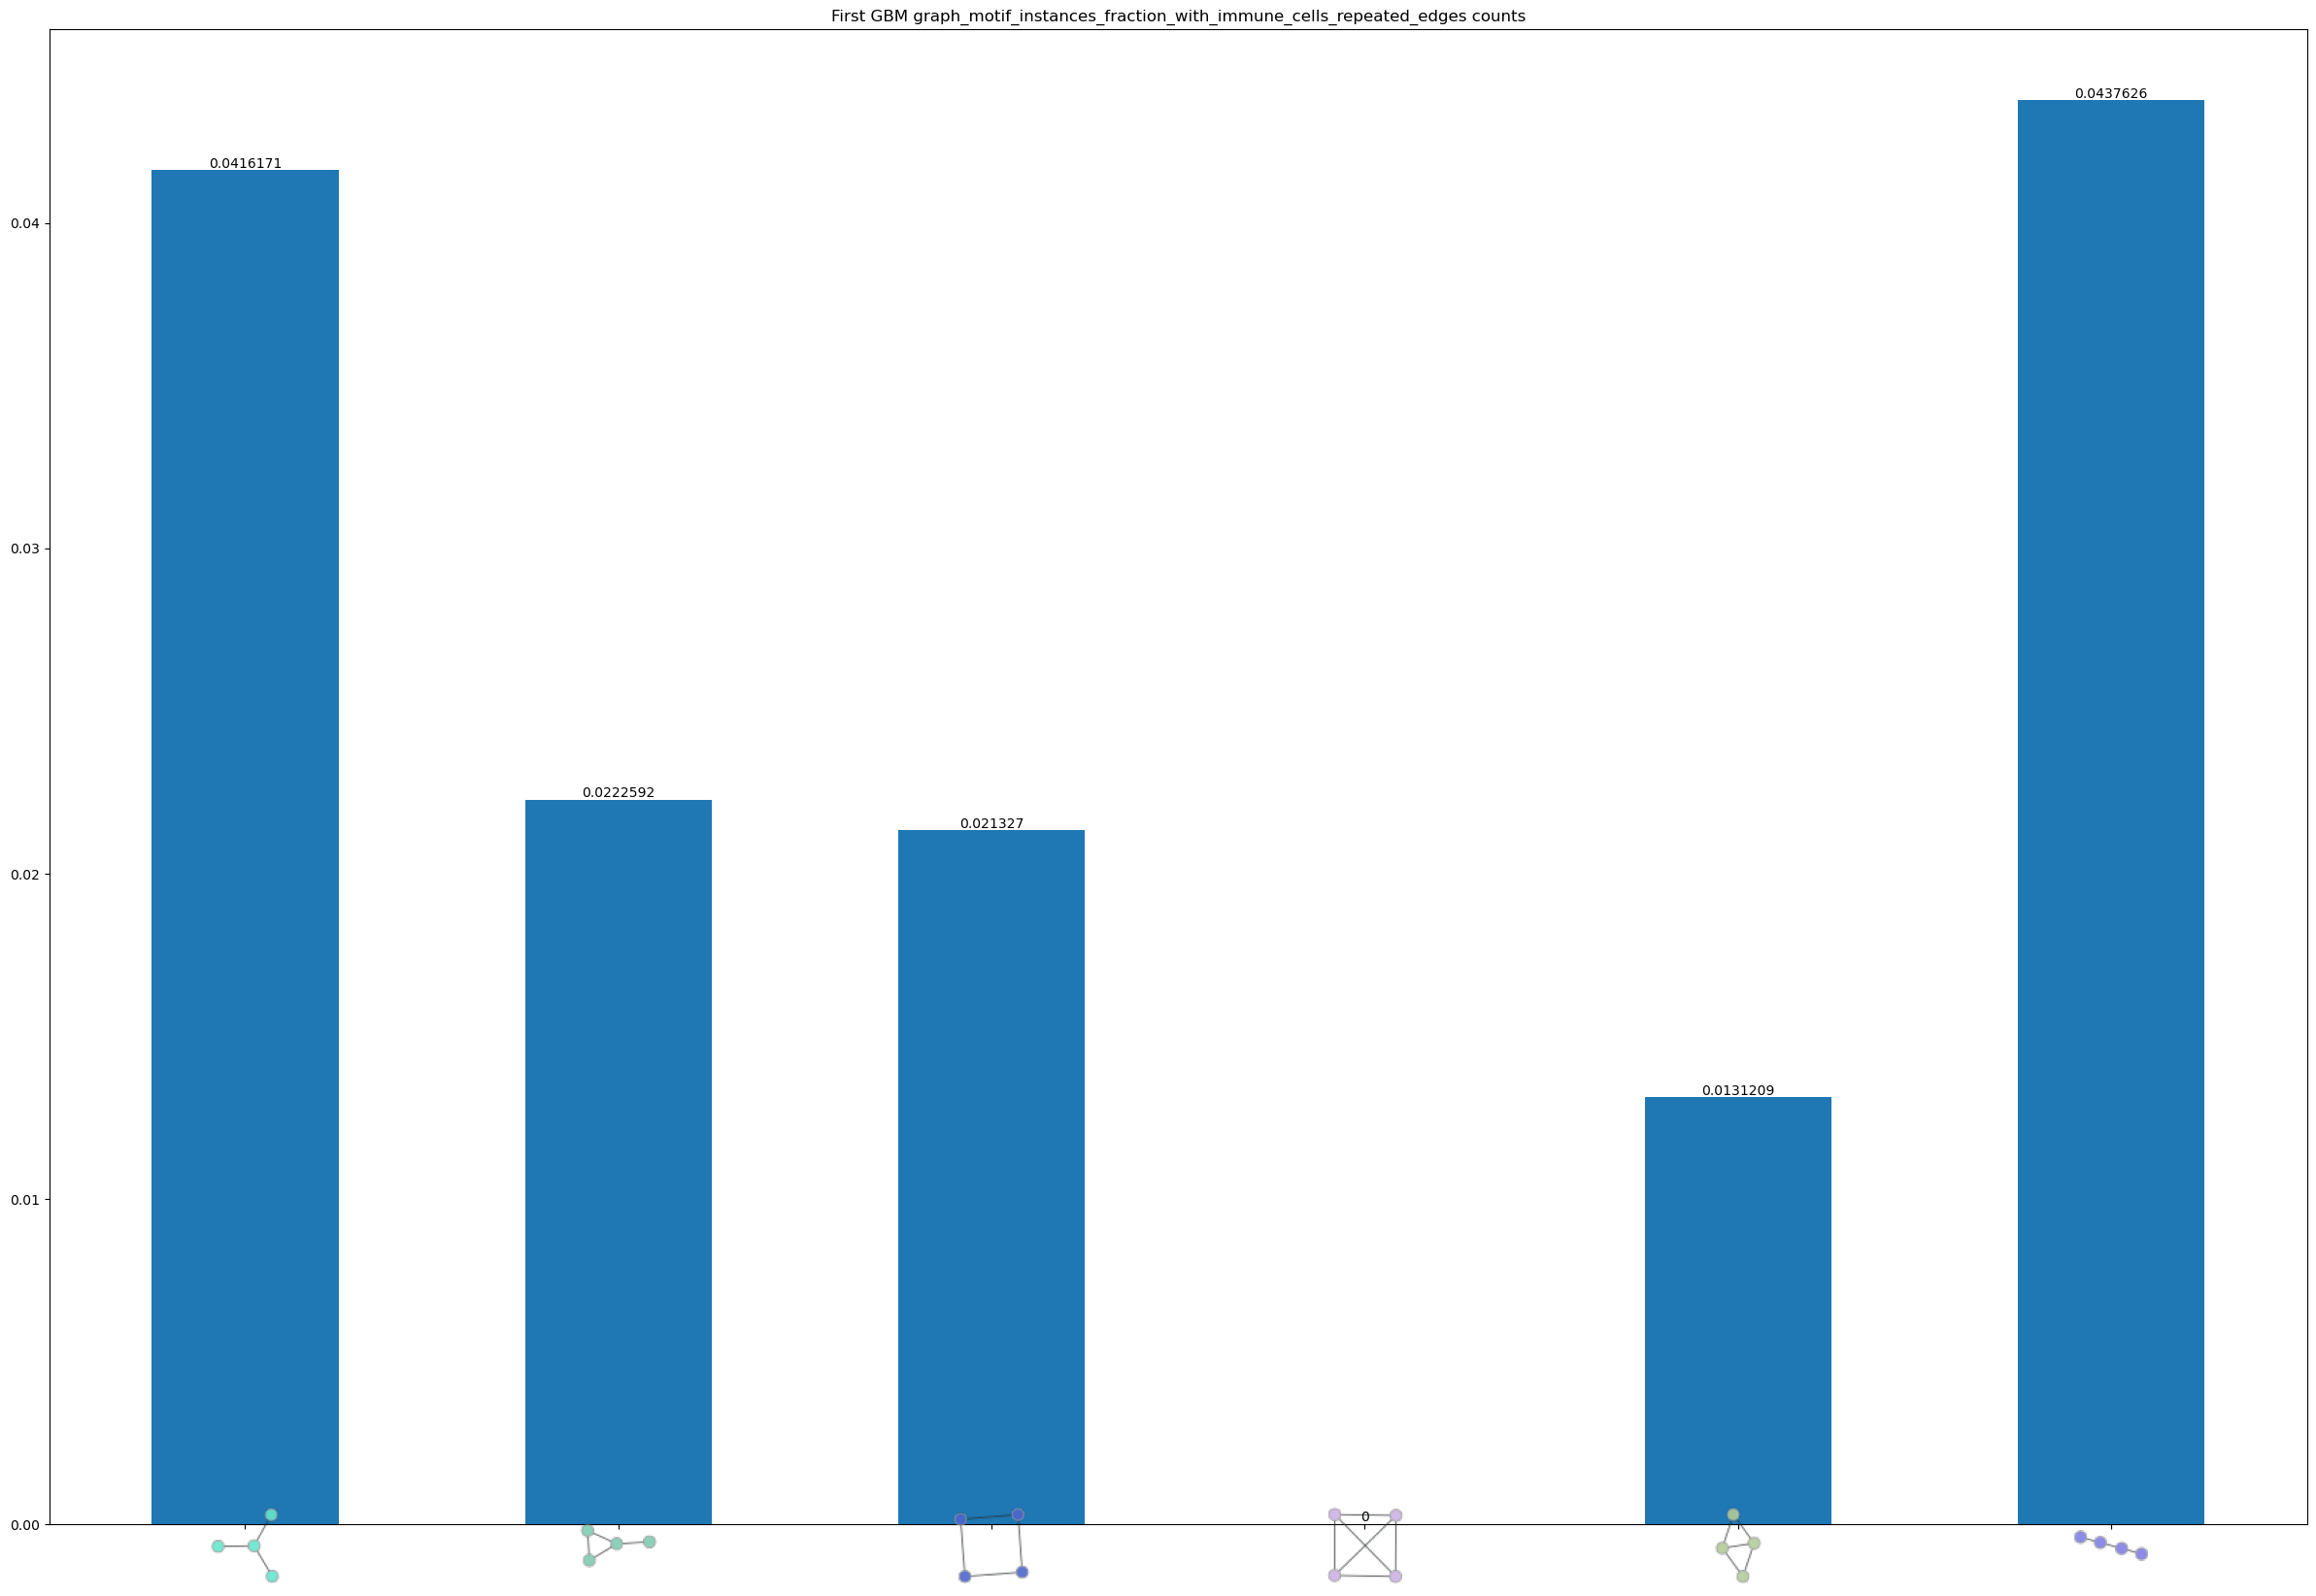

In [51]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_fraction_with_attributes_repeat_edges_allowed.keys()), valuesA=list(motifs_instances_fraction_with_attributes_repeat_edges_allowed.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_fraction_with_immune_cells_repeated_edges")

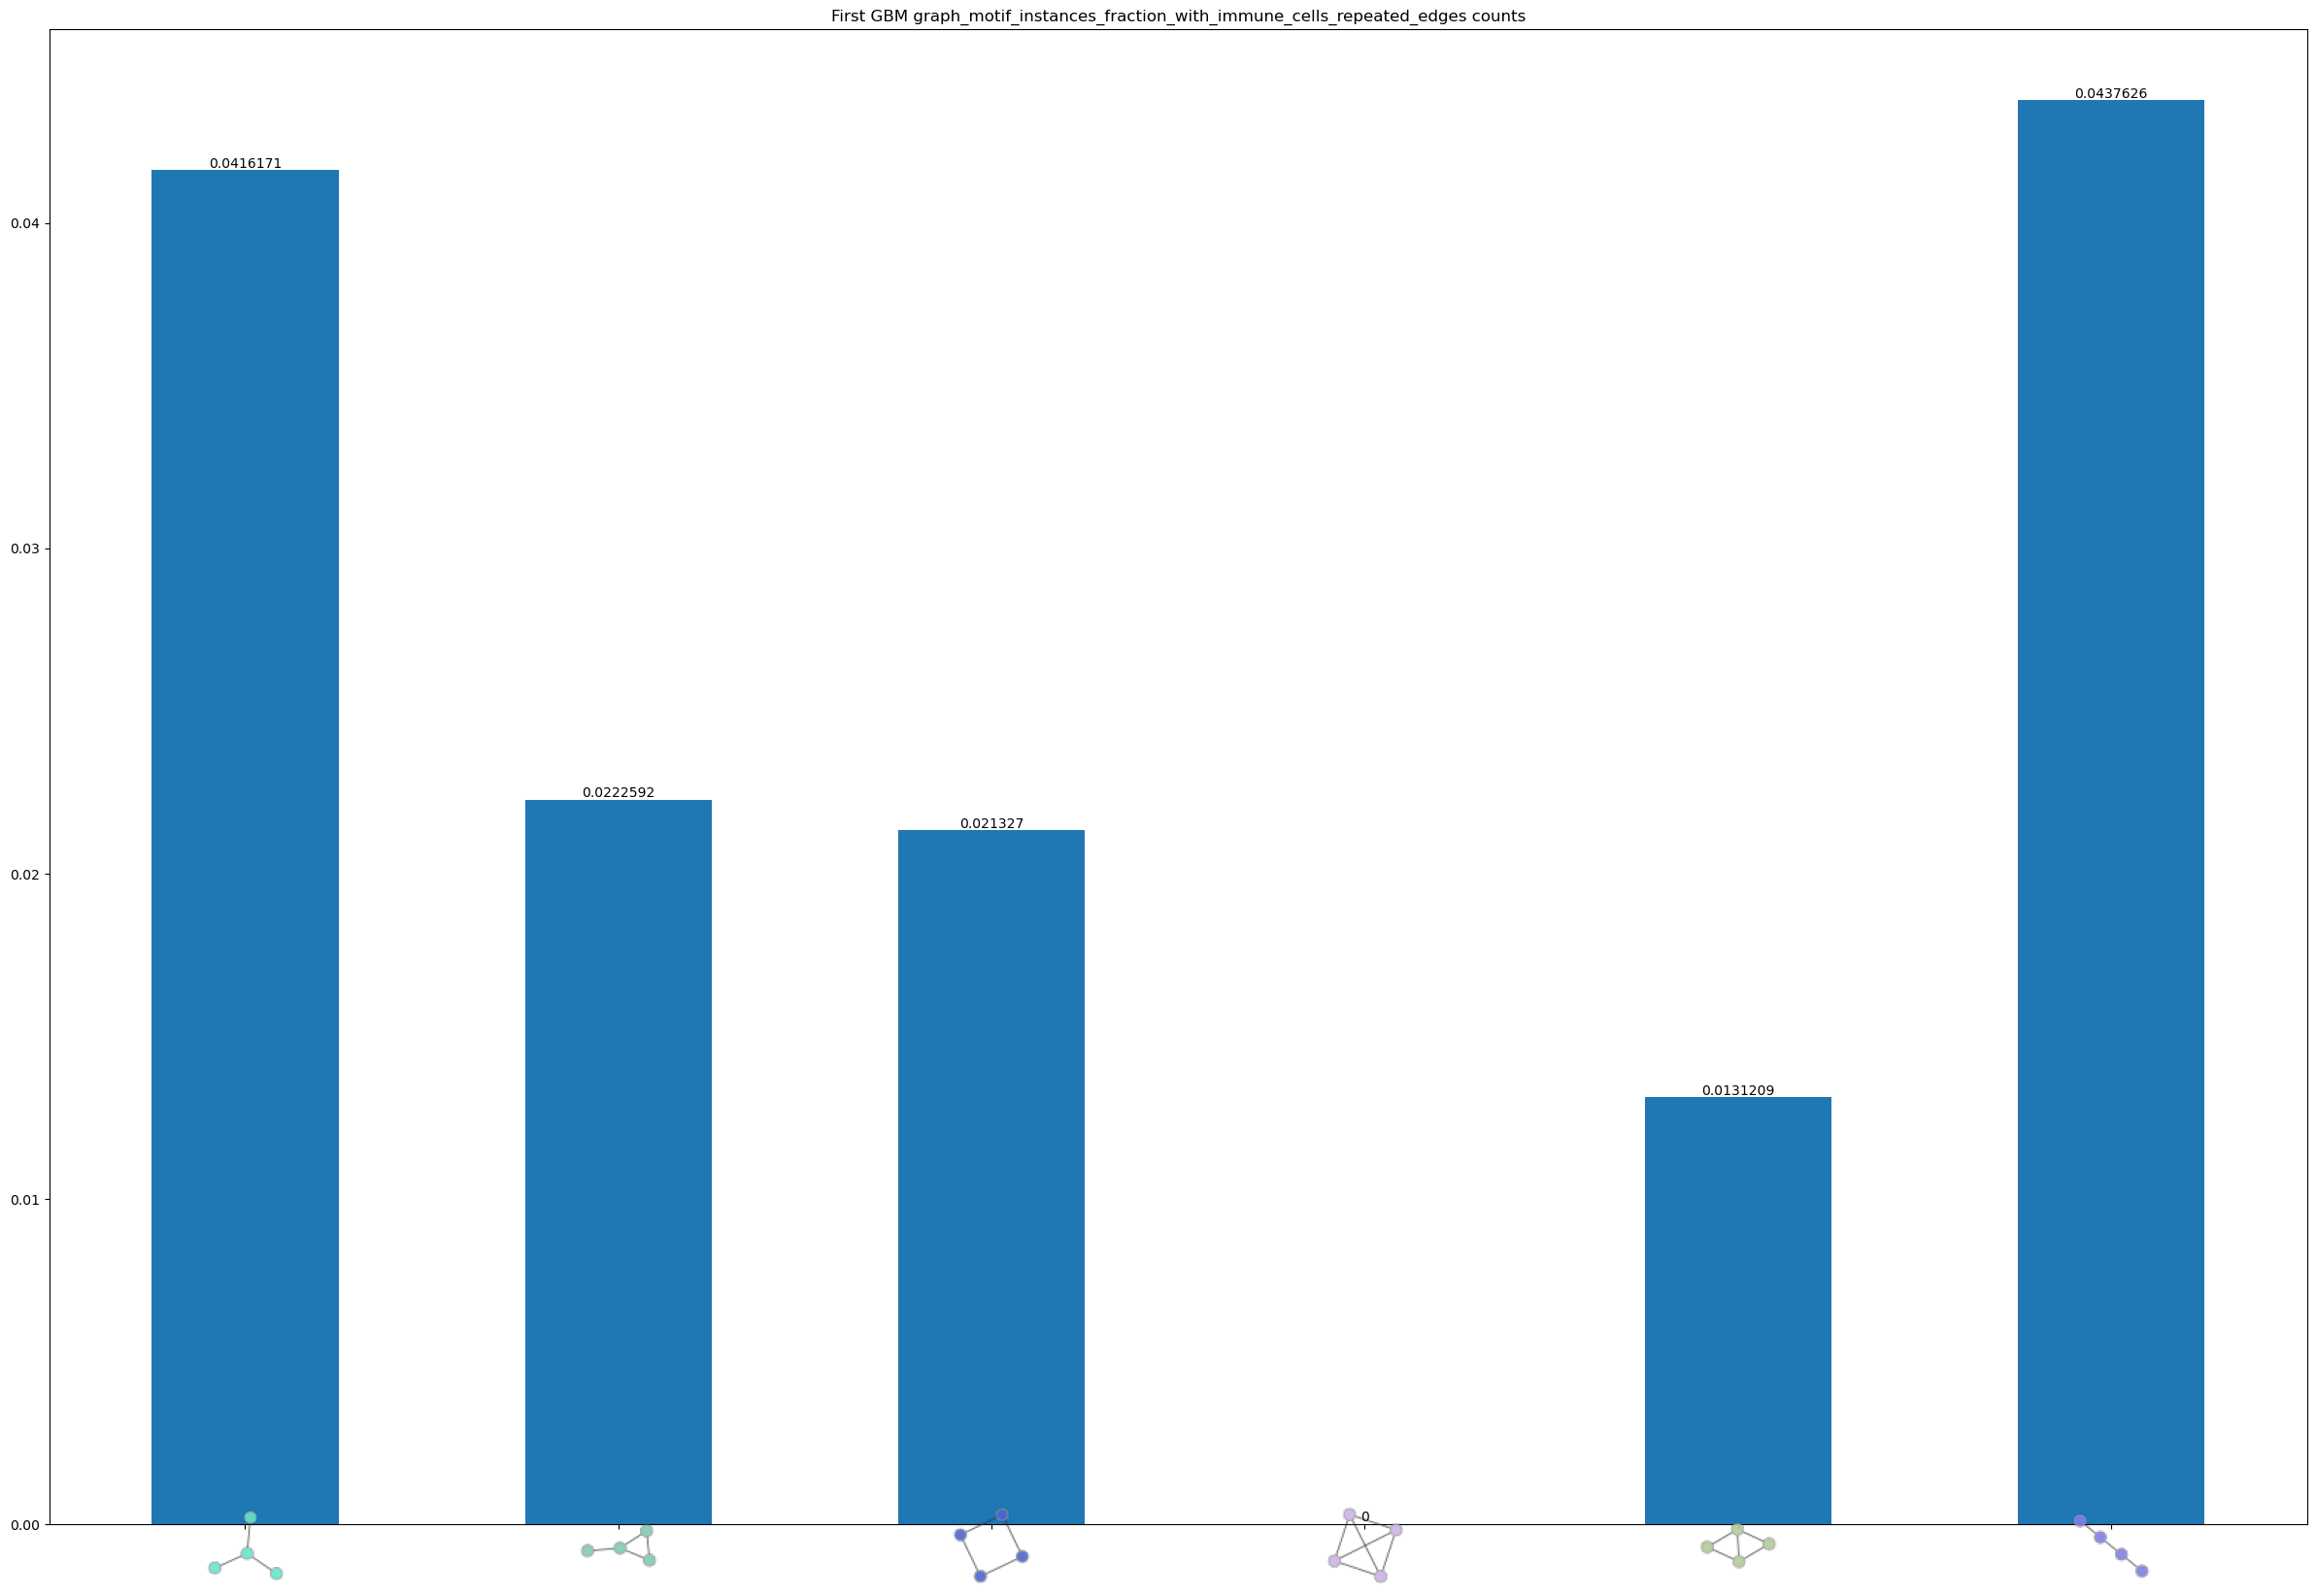

In [52]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_fraction_with_attributes_repeat_edges_not_allowed.keys()), valuesA=list(motifs_instances_fraction_with_attributes_repeat_edges_not_allowed.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_fraction_with_immune_cells_repeated_edges")

### Calculate motifs instances fraction of edges containing immune cells by motif type

In [64]:
def get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(g: Graph,
                                                                              motifs_vertices_lsts_dict: Dict[Graph, List[List[int]]],
                                                                               attribute_to_aggregate:Tuple[str, str]=('e', 'artery_binary'),
                                                                                                include_in_calc_0_containing_edges_instances: bool = True
                                                                              ):
    motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict = {}
    for motif_type, motif_type_vertices_lsts in motifs_vertices_lsts_dict.items():
        visited_edges_in_motif_type = set()
        for vertices_lst in motif_type_vertices_lsts: # iterate each detected motif of the type vertices list (the vertices of the specific instance of the motif)
            motif_instance_num_of_edges_containing_attribute = 0
            # create the possible edges in the motif:
            possible_edges = combinations(vertices_lst.a, 2)
            possible_edges = list(possible_edges)
            # filter the edges not really in the graph, hence not in the motif:
            existing_edges_in_motif = list(map(lambda vertices: g.edge(vertices[0], vertices[1]), list(filter(lambda vertices: g.edge(vertices[0], vertices[1]) is not None, possible_edges))))
            for edge in existing_edges_in_motif: # iterate over all edges in the motif instance
                # check if the edge contains the target attribute (i.e. not zero)
                is_edge_with_attribute = bool(g.properties[attribute_to_aggregate][edge])
                if is_edge_with_attribute:
                    motif_instance_num_of_edges_containing_attribute+=1

            motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict[motif_type] = motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.get(motif_type, []) + [motif_instance_num_of_edges_containing_attribute/len(existing_edges_in_motif)]


    if  include_in_calc_0_containing_edges_instances:
        _motif_type_instances_mean_fraction_of_edges_containing_attribute = {_motif_type: np.mean(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_fraction_of_edges_containing_attribute = {_motif_type: np.std(_motif_type_instances_fractions_of_edges_containing_attribute)
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}
    else:
        _motif_type_instances_mean_fraction_of_edges_containing_attribute = {_motif_type: np.mean(list(filter(lambda x: x!=0, _motif_type_instances_fractions_of_edges_containing_attribute)))
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

        _motif_type_instances_std_fraction_of_edges_containing_attribute = {_motif_type: np.std(list(filter(lambda x: x!=0, _motif_type_instances_fractions_of_edges_containing_attribute)))
                                                for _motif_type, _motif_type_instances_fractions_of_edges_containing_attribute in motifs_instances_fraction_of_edges_with_attribute_by_motif_type_dict.items()}

    return _motif_type_instances_mean_fraction_of_edges_containing_attribute, _motif_type_instances_std_fraction_of_edges_containing_attribute

In [59]:
motifs_instances_mean_fraction_of_edges_with_attributes, motifs_instances_std_fraction_of_edges_with_attributes = get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict
)

### Plot mean fraction of motifs instances edges containing immune cells by motif type

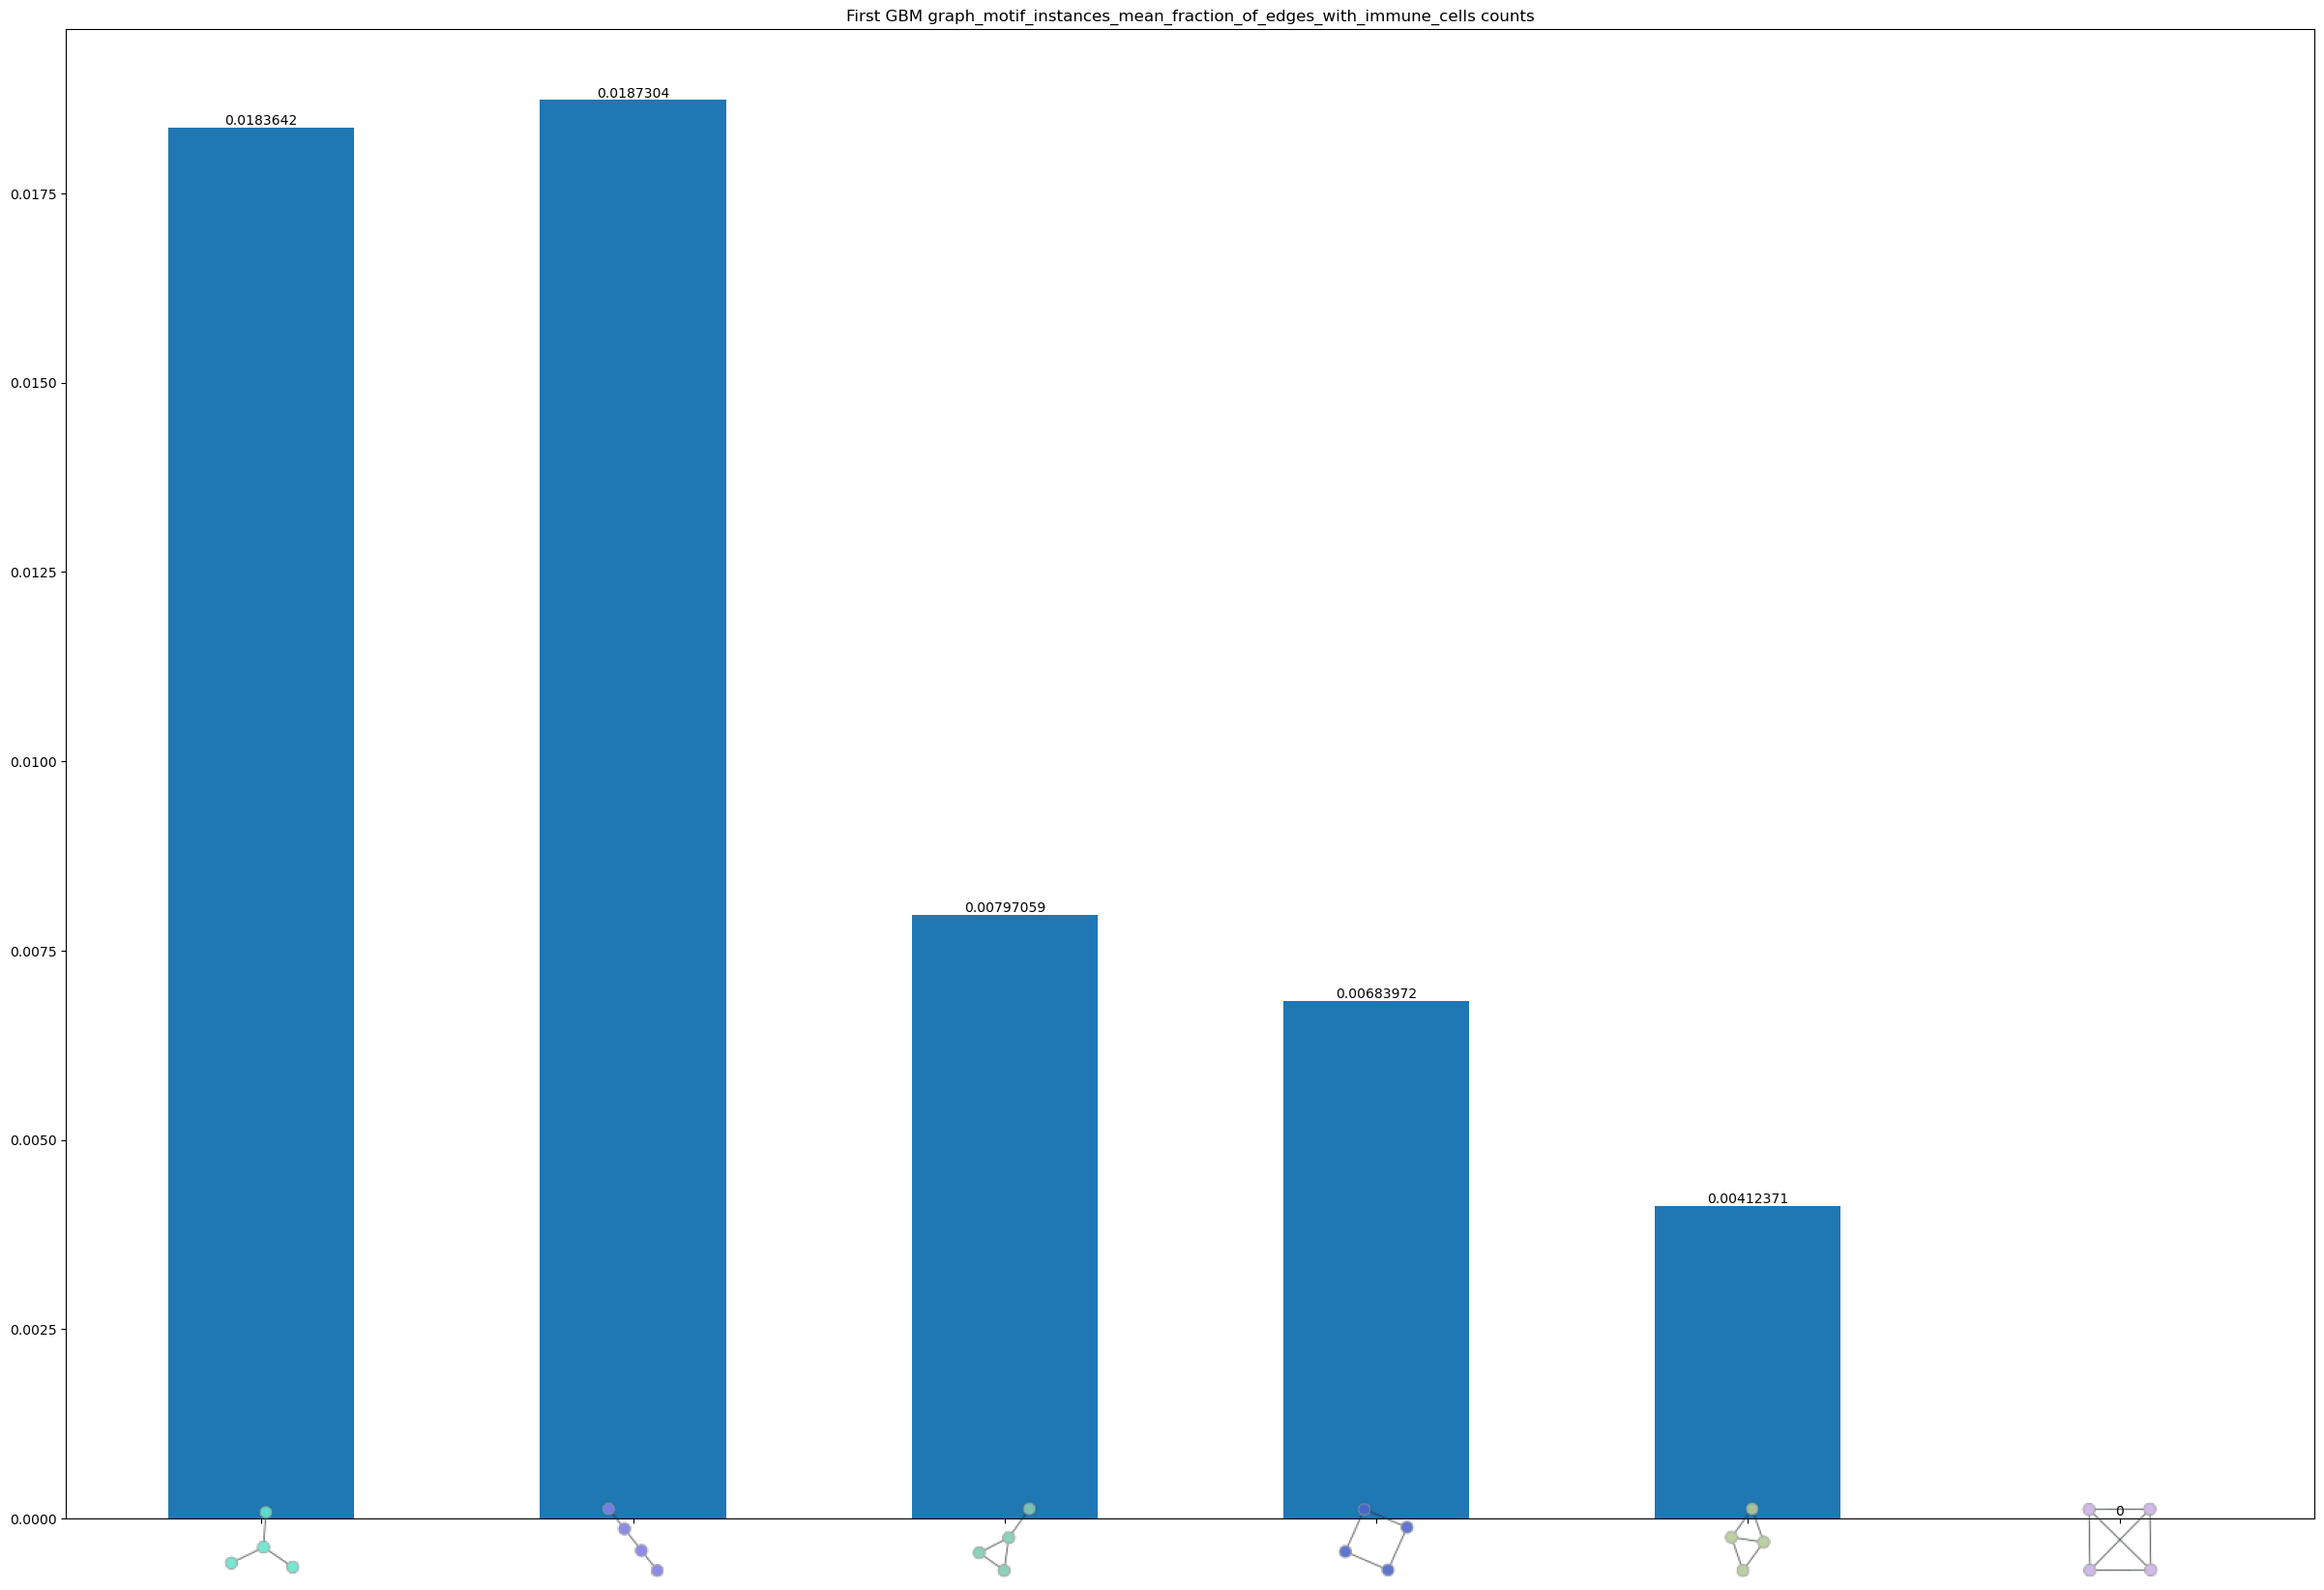

In [60]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_fraction_of_edges_with_attributes.keys()), valuesA=list(motifs_instances_mean_fraction_of_edges_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_fraction_of_edges_with_immune_cells")

### Plot std fraction of motifs instances edges containing immune cells in edges by motif type

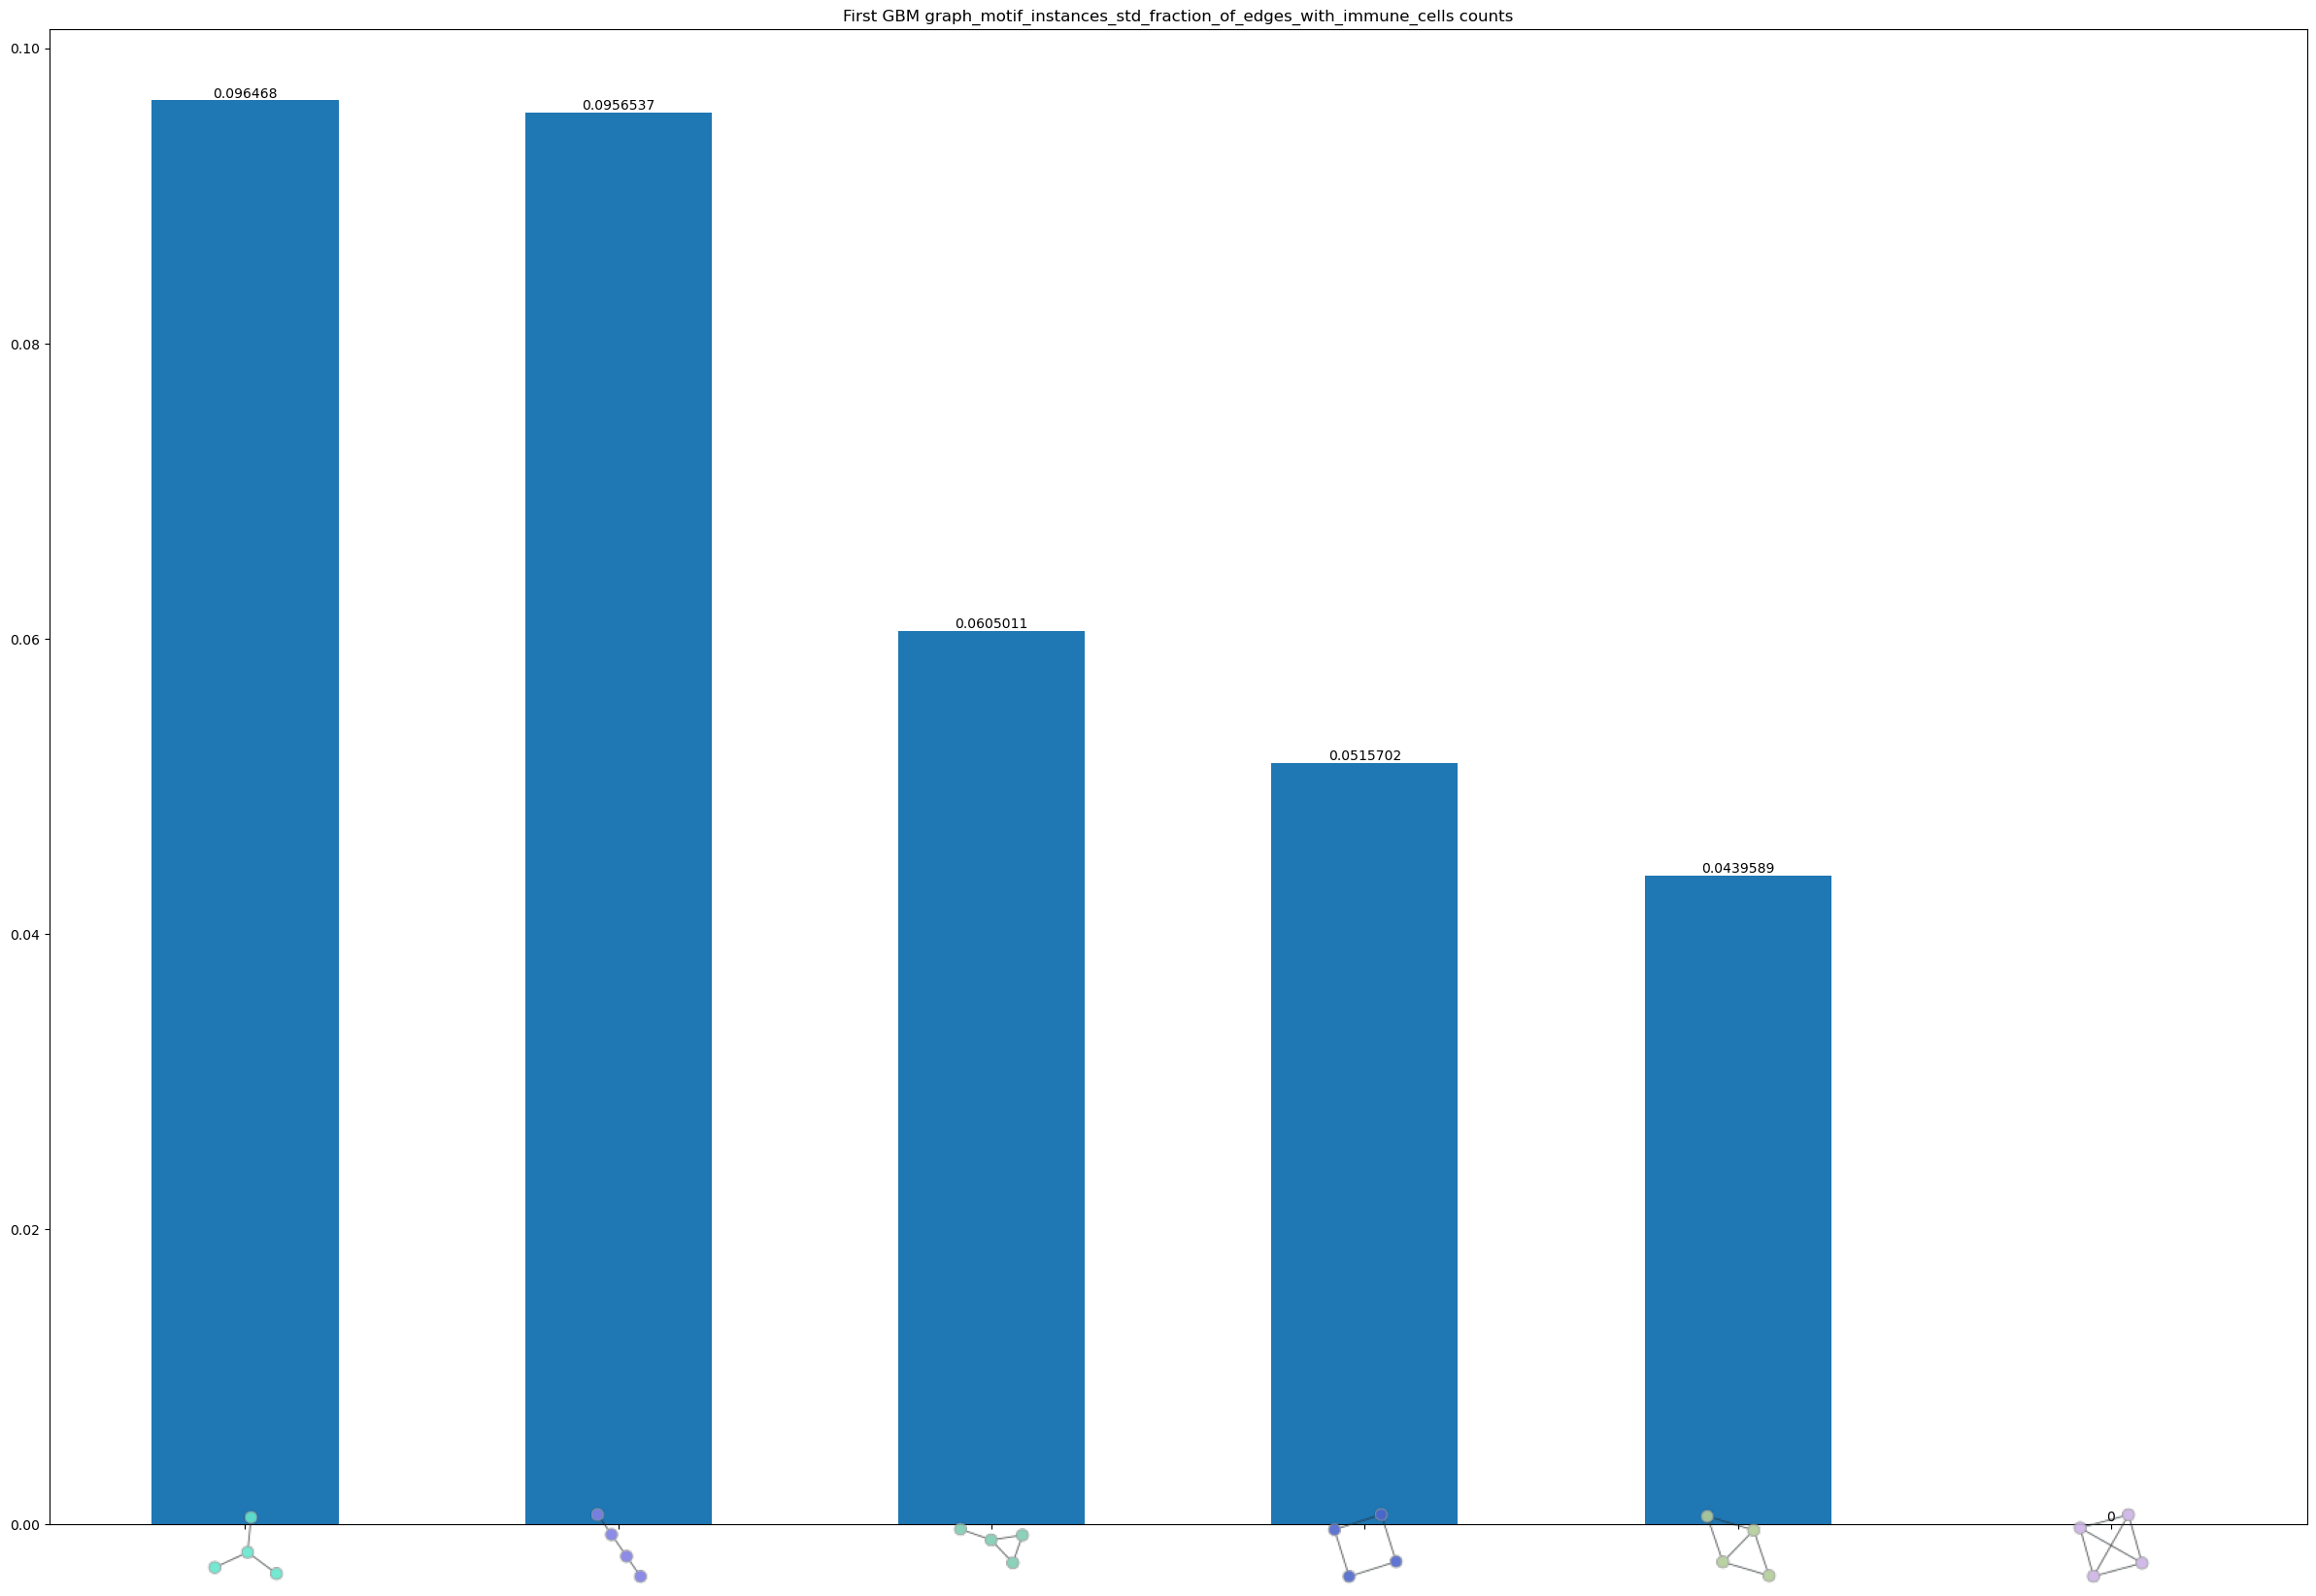

In [61]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_std_fraction_of_edges_with_attributes.keys()), valuesA=list(motifs_instances_std_fraction_of_edges_with_attributes.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_std_fraction_of_edges_with_immune_cells")

### Calculate mean & std fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)

In [65]:
motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances, motifs_instances_std_fraction_of_edges_with_attributes_no_empty_instances = get_edge_existing_attribute_motifs_instances_mean_and_std_fraction_of_edges_with_attributes(
    g=g,
    motifs_vertices_lsts_dict=motifs_vertices_lsts_dict,
    include_in_calc_0_containing_edges_instances = False
)

/Users/yishaiazabary/miniforge3/envs/GraphTool/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yishaiazabary/miniforge3/envs/GraphTool/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yishaiazabary/miniforge3/envs/GraphTool/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yishaiazabary/miniforge3/envs/GraphTool/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/yishaiazabary/miniforge3/envs/GraphTool/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scala

### Plot mean fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)


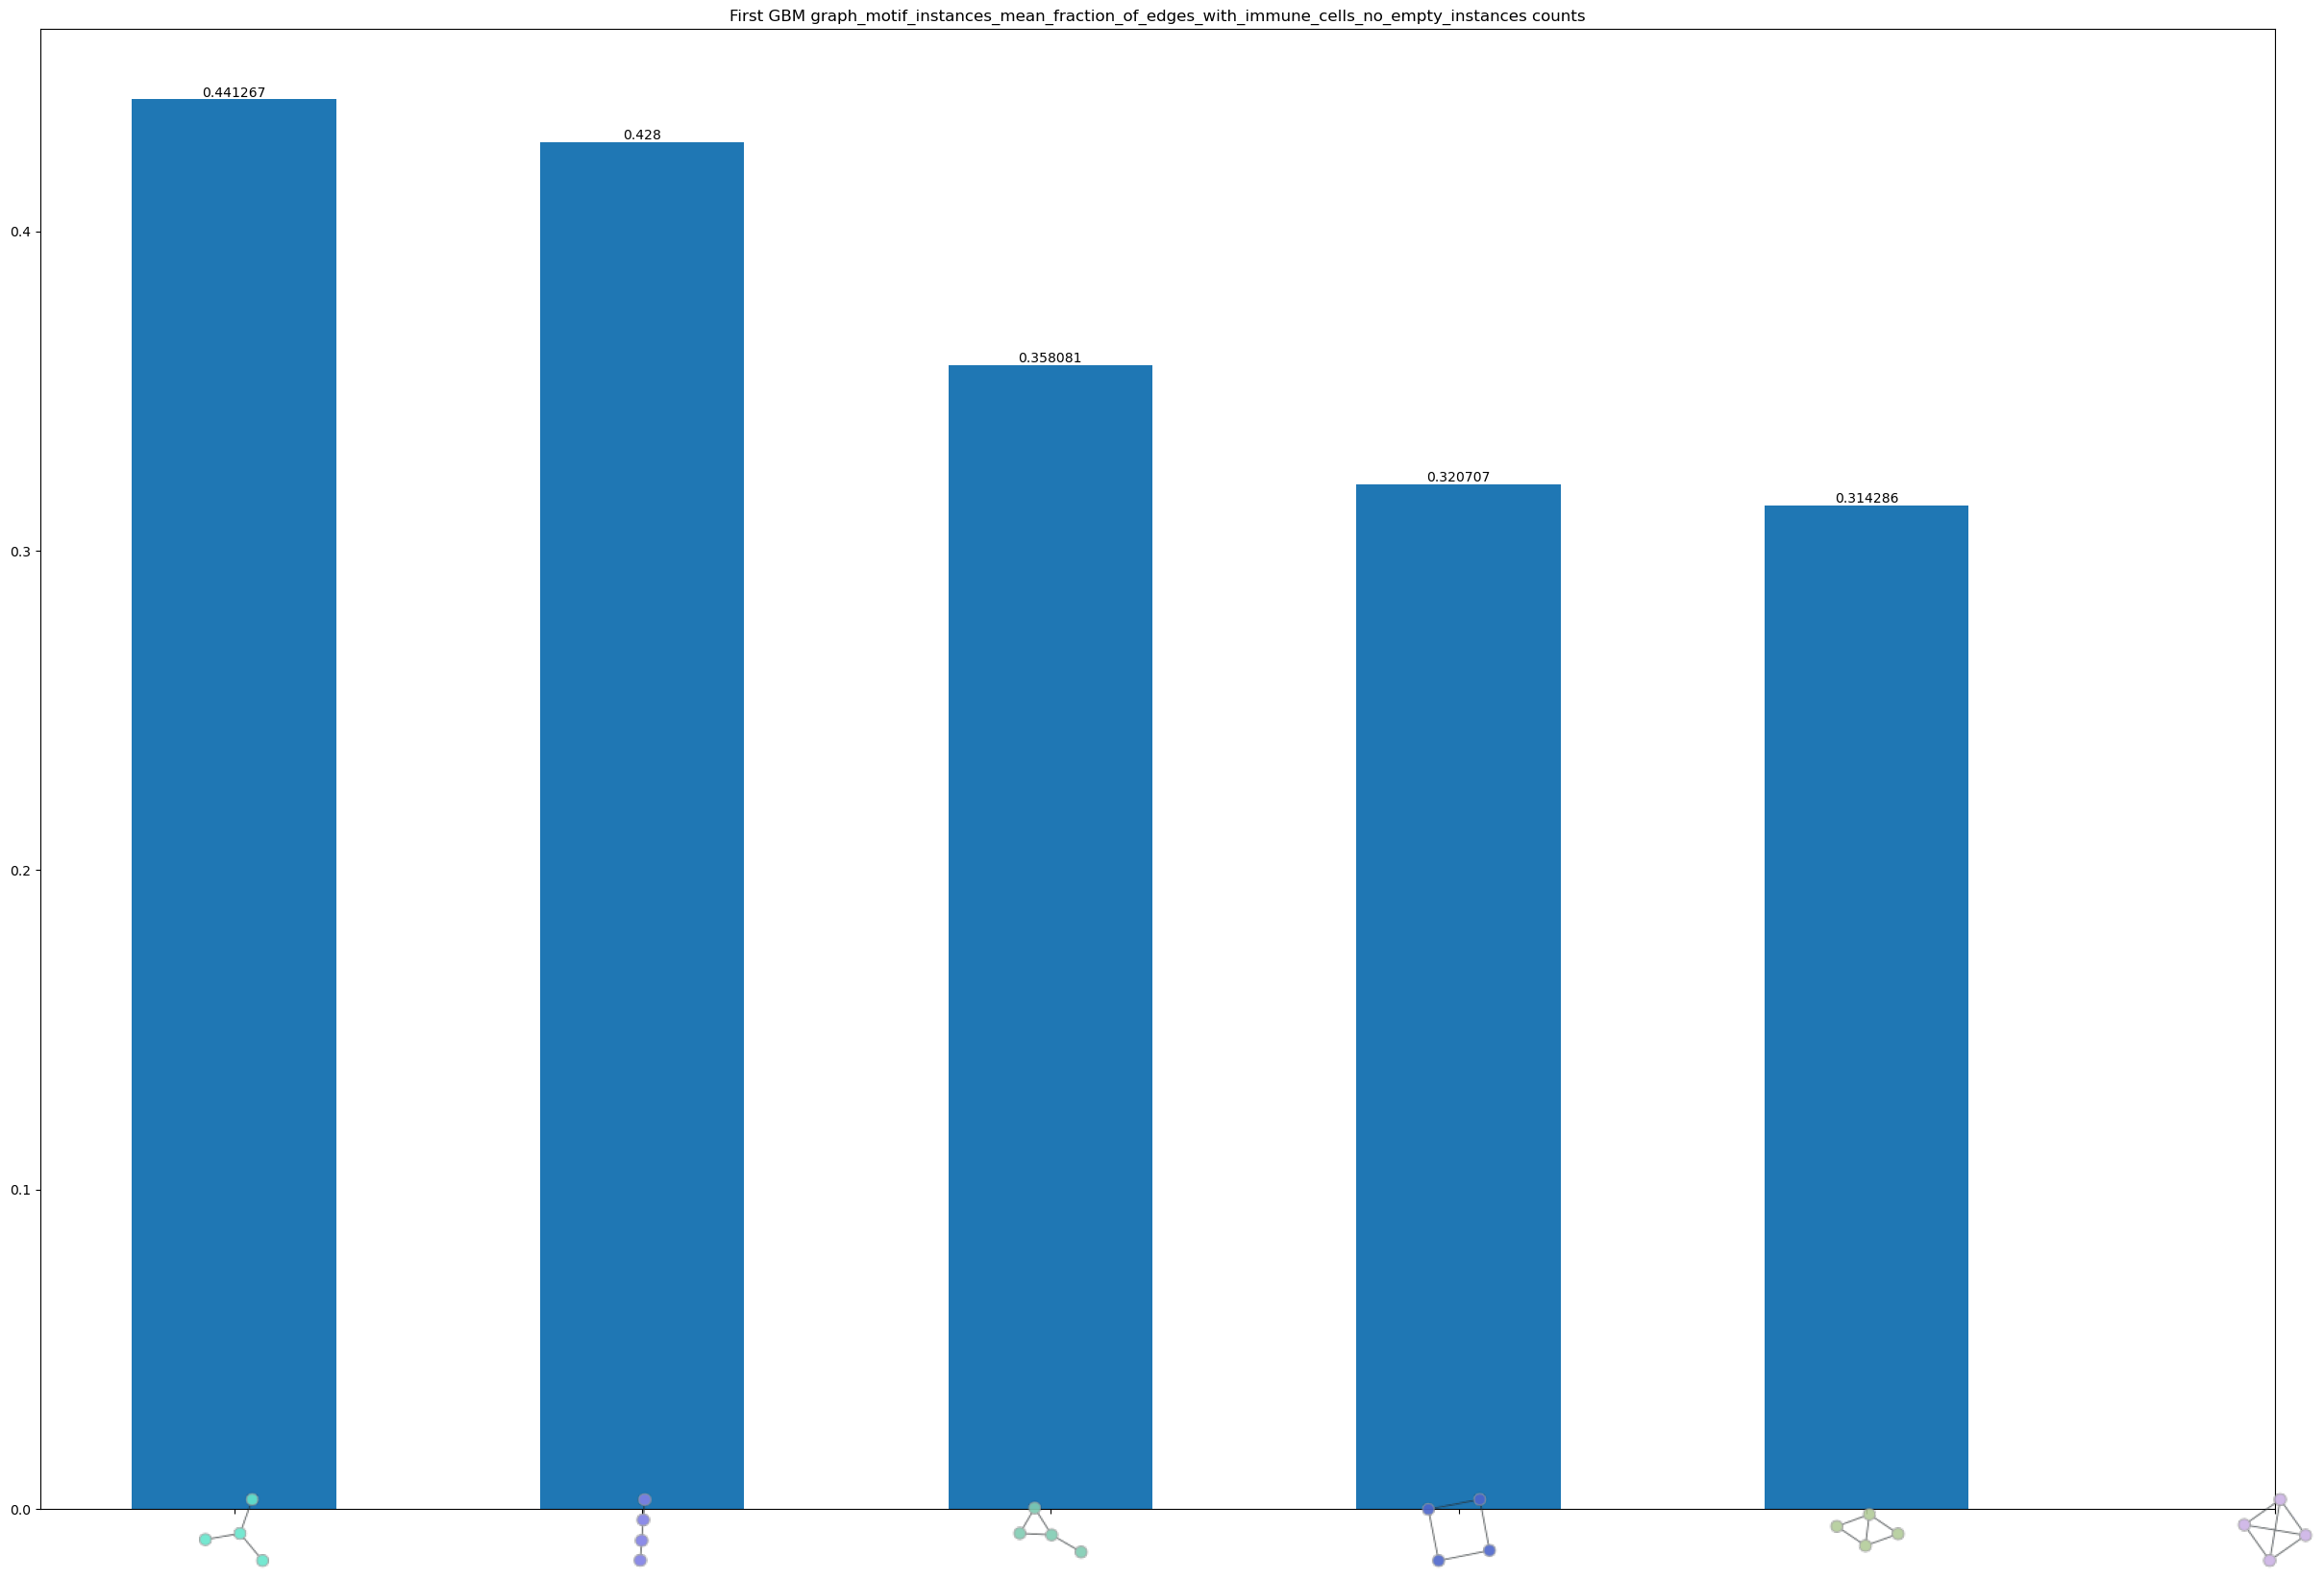

In [66]:
plot_motif_cnts_per_type(motifs_types=list(motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances.keys()), valuesA=list(motifs_instances_mean_fraction_of_edges_with_attributes_no_empty_instances.values()), path_to_save_plot_dir="", subgraph_name="First GBM graph_motif_instances_mean_fraction_of_edges_with_immune_cells_no_empty_instances")

### Plot std fraction of motifs instances edges containing immune cells in edges by motif type excluding empty instances (motif instances with no immune cells)

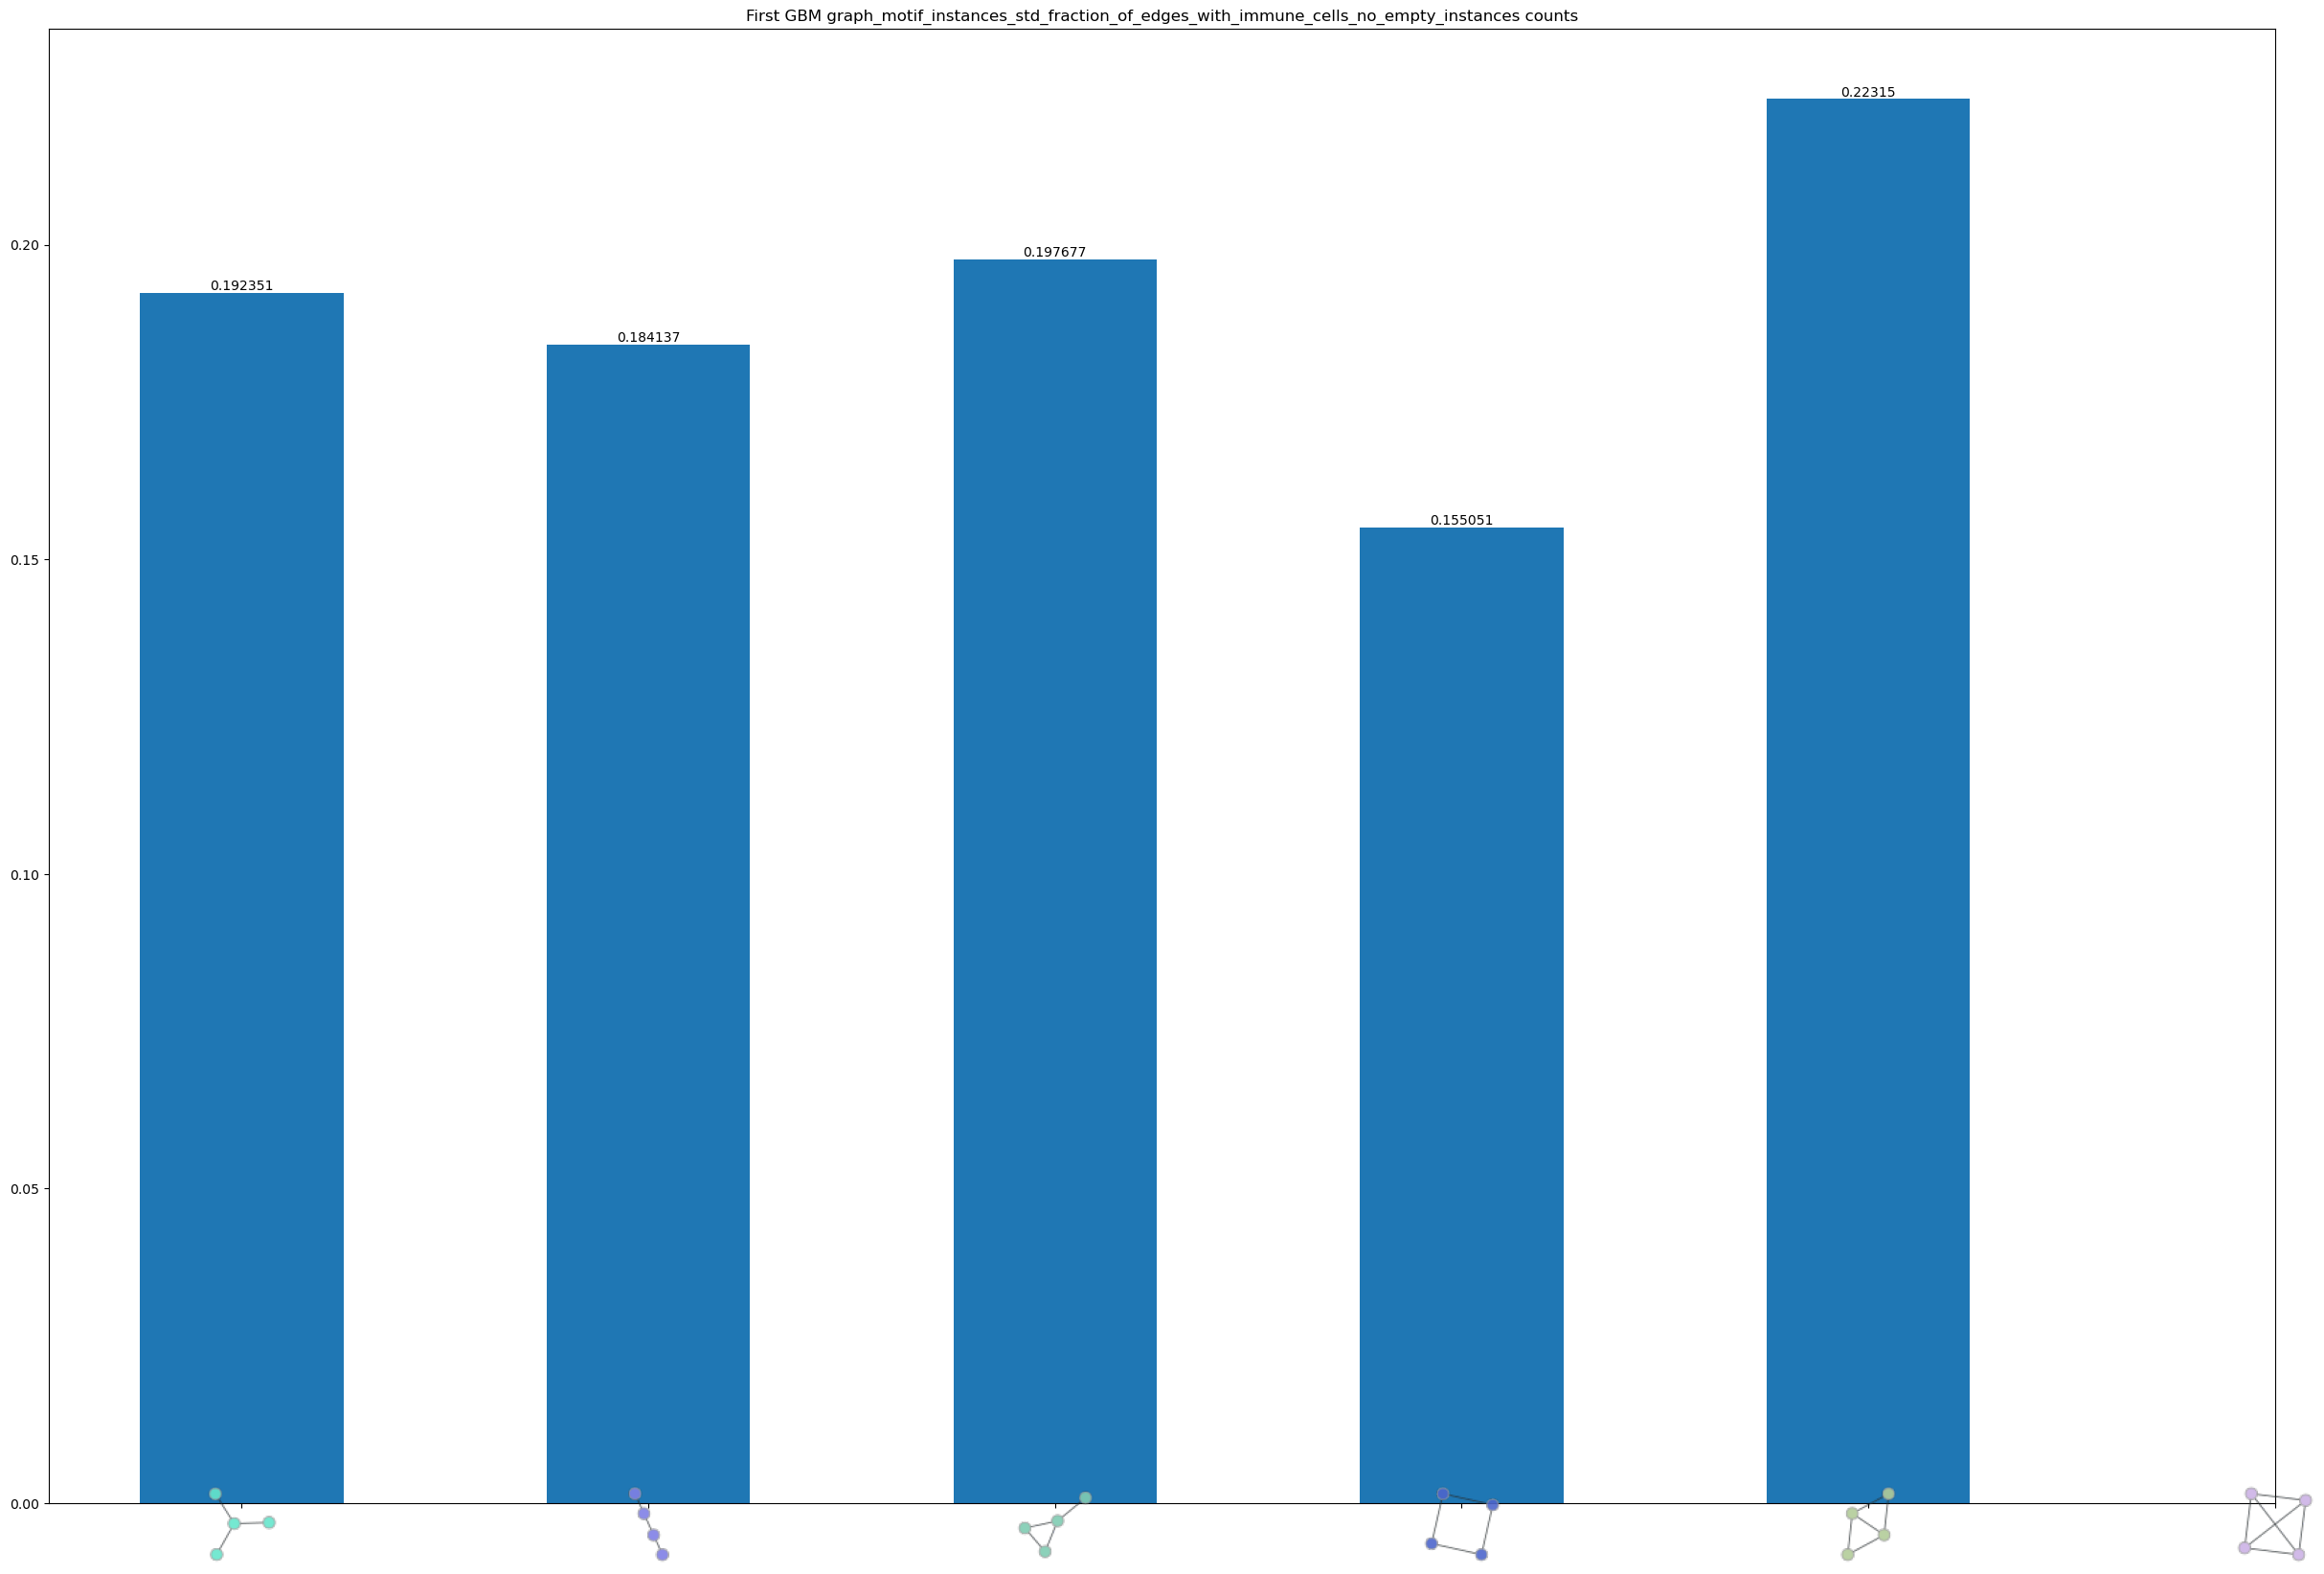

In [67]:
eeee="eeFirst GBM graph_motif_instances_std_fraction_of_edges_with_immune_cells_no_empty_instances")

In [ ]:
e